# Task

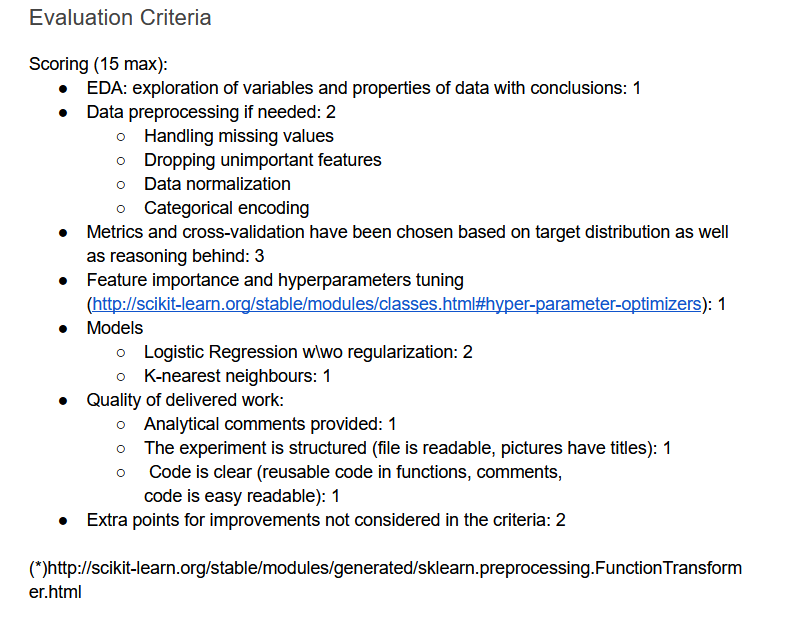

# imports

In [14]:
! jt -t onedork

/bin/bash: jt: command not found


In [15]:
! pip install bds_courseware

In [86]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import svm, datasets
import plotly.express as px

from bds_courseware import get_dataset

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['figure.figsize'] = 7, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# global methods

In [65]:
def correlation_heatmap(dataframe, coefficient):
    correlation = dataframe.corr(method=coefficient)
    cols = correlation.index
    f, ax = plt.subplots(figsize = (15,10))
    sns.heatmap(correlation, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='coolwarm',
            linecolor="white", xticklabels = cols.values , annot_kws = {'size':12}, yticklabels = cols.values)
    


# EDA

lets load the data

In [17]:
data = get_dataset("hypothyroid")
data.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

replace ? with NaNs

In [19]:
data.replace(to_replace='?', inplace=True, value=np.NaN)
print(data.isnull().sum())

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

variable TBG contains too many missing values

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'heatmap of missing values')

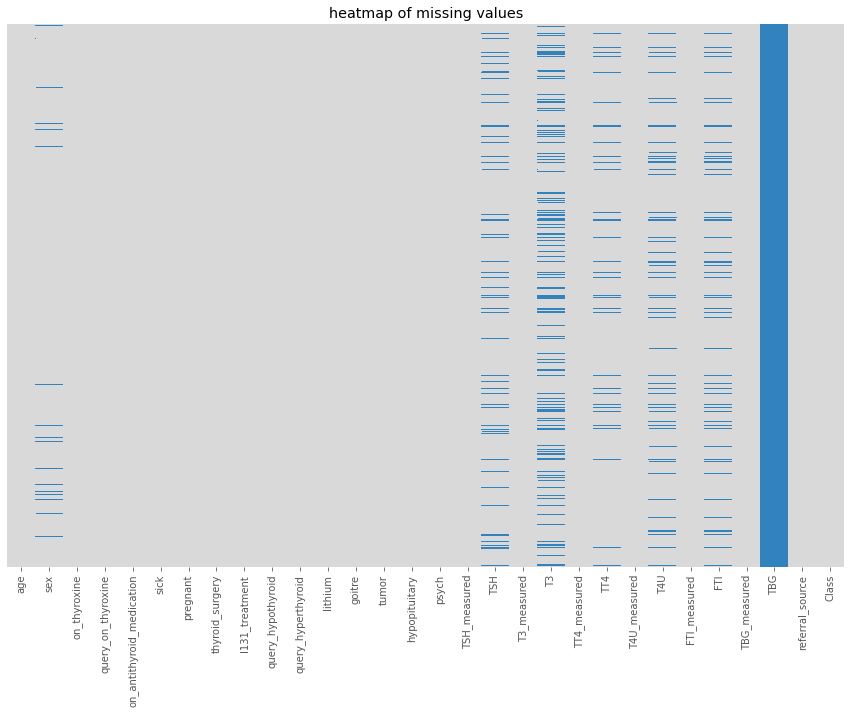

In [20]:
plt.figure(figsize = (15,10))
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'tab20c_r')
plt.title('heatmap of missing values')

the whole column TBG consists of missing values. we should definitely drop it. as description says the dataset might be corrupted

In [21]:
data.drop(columns=["TBG"], inplace=True)

there is only 1 missing value in age columns. let's remove this row from df

In [22]:
data = data[data['age'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3771 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3771 non-null   object
 1   sex                        3621 non-null   object
 2   on_thyroxine               3771 non-null   object
 3   query_on_thyroxine         3771 non-null   object
 4   on_antithyroid_medication  3771 non-null   object
 5   sick                       3771 non-null   object
 6   pregnant                   3771 non-null   object
 7   thyroid_surgery            3771 non-null   object
 8   I131_treatment             3771 non-null   object
 9   query_hypothyroid          3771 non-null   object
 10  query_hyperthyroid         3771 non-null   object
 11  lithium                    3771 non-null   object
 12  goitre                     3771 non-null   object
 13  tumor                      3771 non-null   object
 14  hypopitu

now we can look through data to search for some interesting patterns/findings

## target variable

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Target variable analysis')

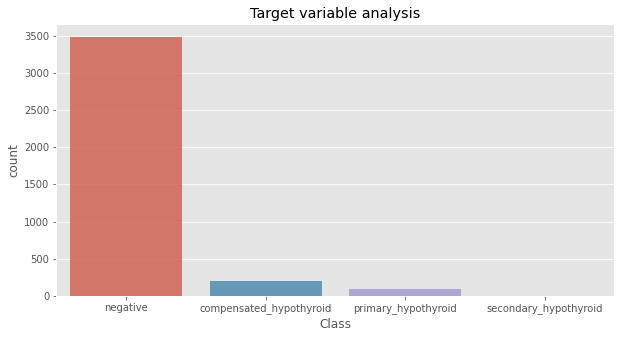

In [25]:
plt.figure(figsize = (10, 5))
sns.countplot(data["Class"], alpha =.80)
plt.title('Target variable analysis')
plt.ylabel('Number of specimen')

we see that there are too many negative cases. let's count the exact number of positive cases

In [28]:
print(data.groupby(['Class']).Class.count())

Class
compensated_hypothyroid     194
negative                   3480
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64


there are 291 positive cases against 3480 negative. we should probably combine all positive cases into new variable - positive.

## numeric features

we know that our data has been imported as type object. let's convert it to float64 and int64

In [39]:
numeric_features = ["age", "TSH", "T3", "TT4", "T4U", "FTI"]
data[numeric_features] = data[numeric_features].astype(float)

now we got all numeric features in one hand. according to this [paper](https://ieeexplore.ieee.org/abstract/document/9002284) all measured data are thyroid hormone levels 



In [40]:
data_numeric = data.select_dtypes(include=["int64", "float64"])
data_numeric.head(10)
continous_data = []
for col in data_numeric.columns: 
    continous_data.append(col) 

,age,TSH,T3,TT4,T4U,FTI
0,41.0,1.30,2.5,125.0,1.14,109.0
1,23.0,4.10,2.0,102.0,NaN,NaN
2,46.0,0.98,NaN,109.0,0.91,120.0
3,70.0,0.16,1.9,175.0,NaN,NaN
4,70.0,0.72,1.2,61.0,0.87,70.0
5,18.0,0.03,NaN,183.0,1.30,141.0
6,59.0,NaN,NaN,72.0,0.92,78.0
7,80.0,2.20,0.6,80.0,0.70,115.0
8,66.0,0.60,2.2,123.0,0.93,132.0
9,68.0,2.40,1.6,83.0,0.89,93.0


<Figure size 1440x720 with 0 Axes>

Text(0.5, 1.0, 'Target variable analysis')

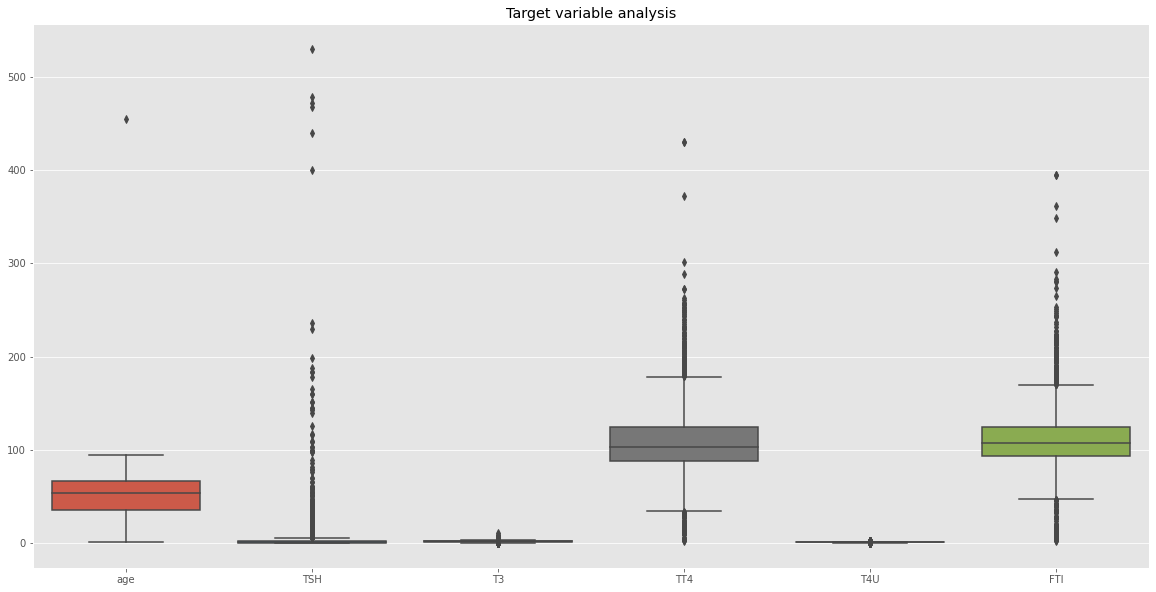

In [46]:
plt.figure(figsize = (20, 10))
sns.boxplot(data=data)
plt.title('Target variable analysis')

the data contains outliers. however, we can't discard them as they could provide the explanatory power to our model (abnormal level of hormones may indicate the presence of thyroid disease). maybe we should look into range of hormone scale and use it as cut-off for outliers handling. the one outlier in age variable should be dropped. 

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Age distribution')

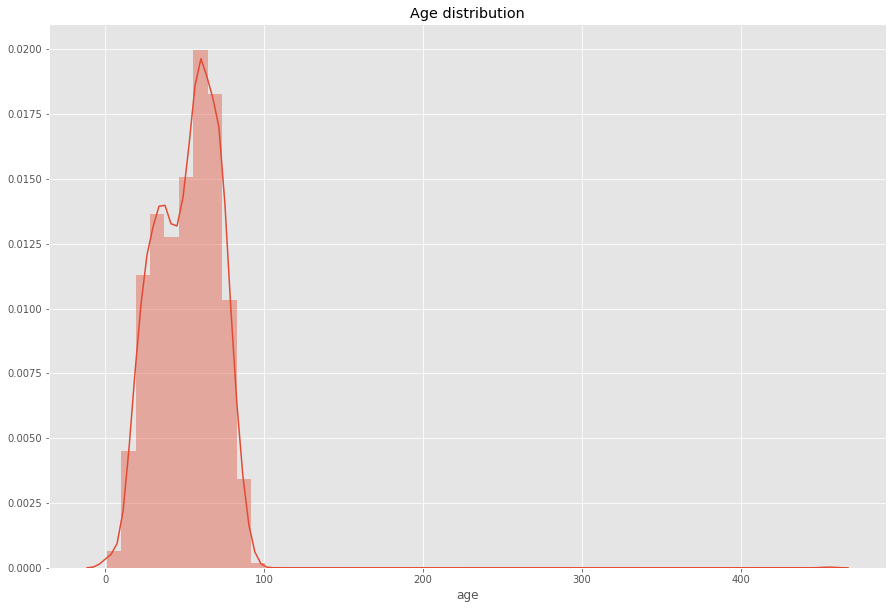

In [53]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["age"], norm_hist=True)
ax.set_title('Age distribution')

with an exception of outlier the distribution is acceptable for our task. we can scale it with StandardScaler

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'Age distribution')

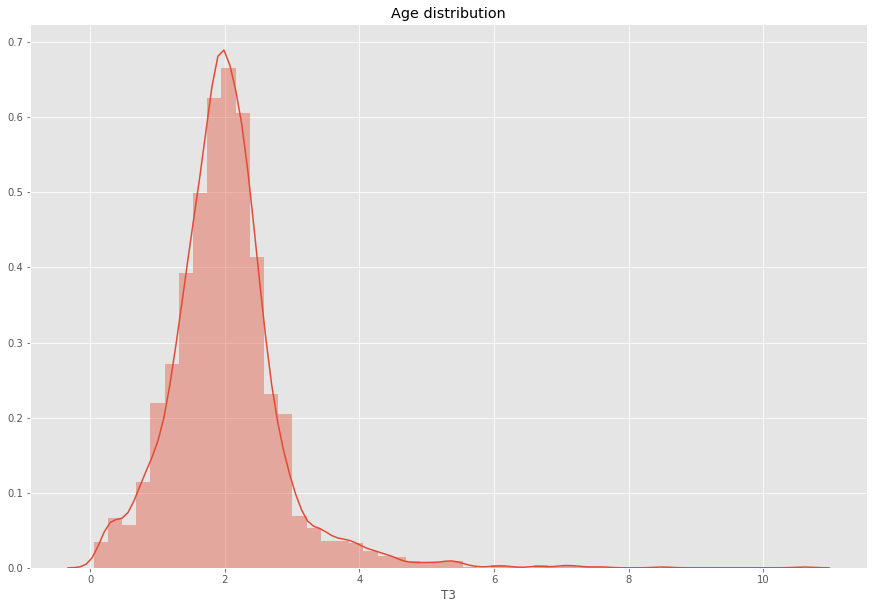

In [54]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["T3"], norm_hist=True)
ax.set_title('T3 distribution')

the distribution looks good. we can also use StandardScaler here

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'TT4 distribution')

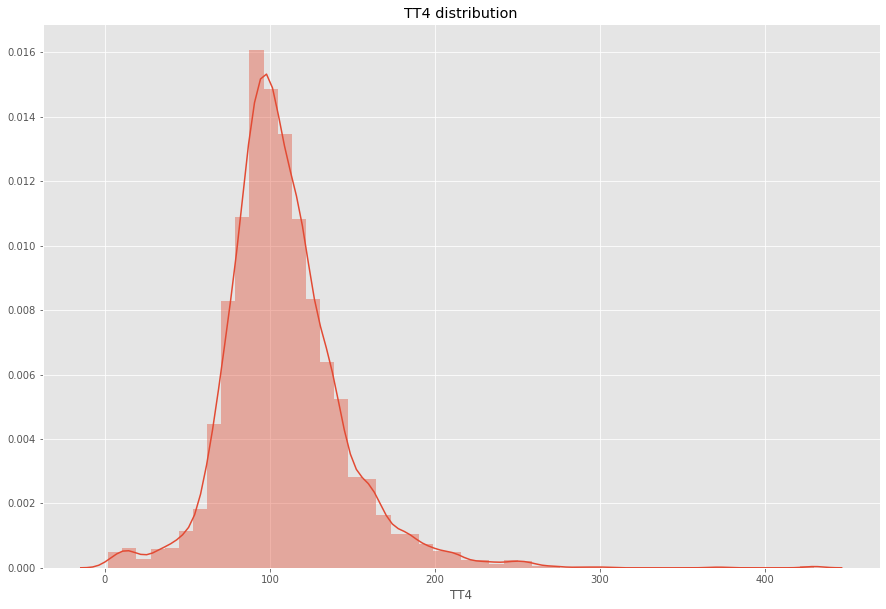

In [55]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["TT4"], norm_hist=True)
ax.set_title('TT4 distribution')

in this case the range is too large. we should probably omit outliers

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'TSH distribution')

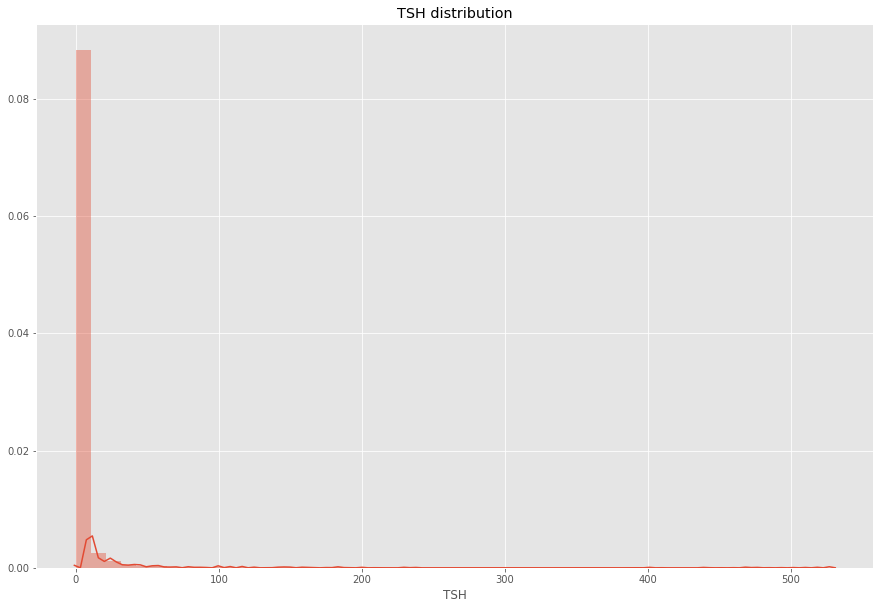

In [56]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["TSH"], norm_hist=True)
ax.set_title('TSH distribution')

the variable is drastically unbalanced. perhaps we should apply robustscaler or outlier removal

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'T4U distribution')

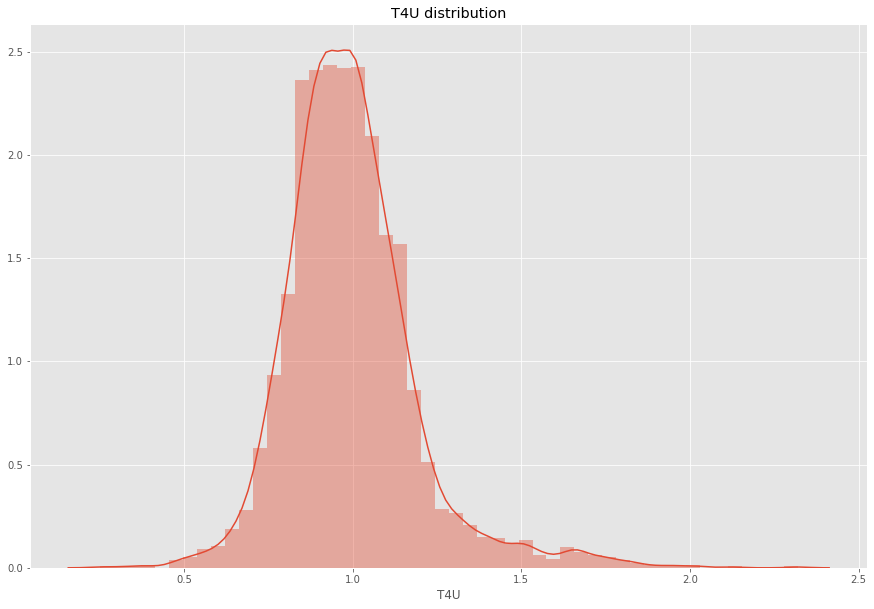

In [57]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["T4U"], norm_hist=True)
ax.set_title('T4U distribution')

decent distrubition. good for StandardScaler

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'FTI distribution')

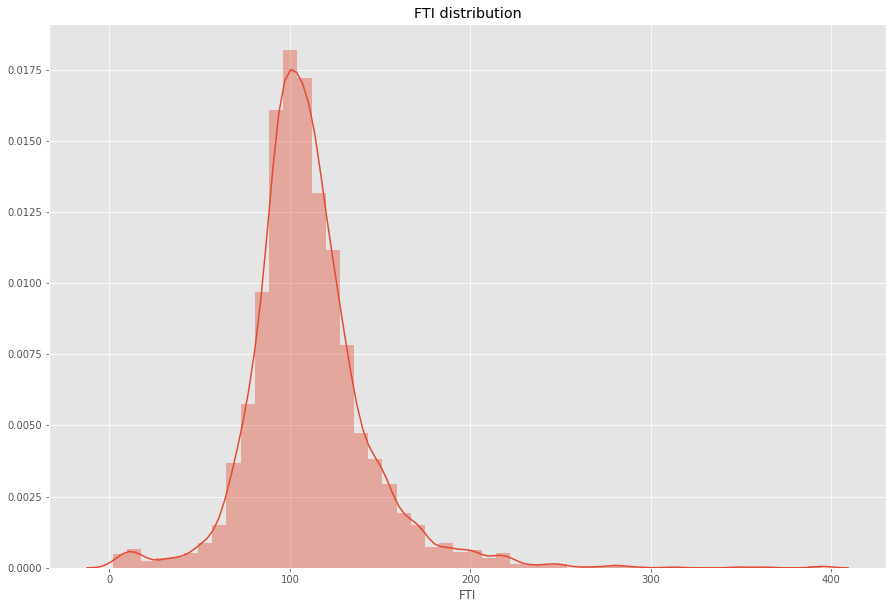

In [58]:
plt.figure(figsize = (15, 10))
ax = sns.distplot(data["FTI"], norm_hist=True)
ax.set_title('FTI distribution')

this plot looks similar to TT4. we should investigate the correlations

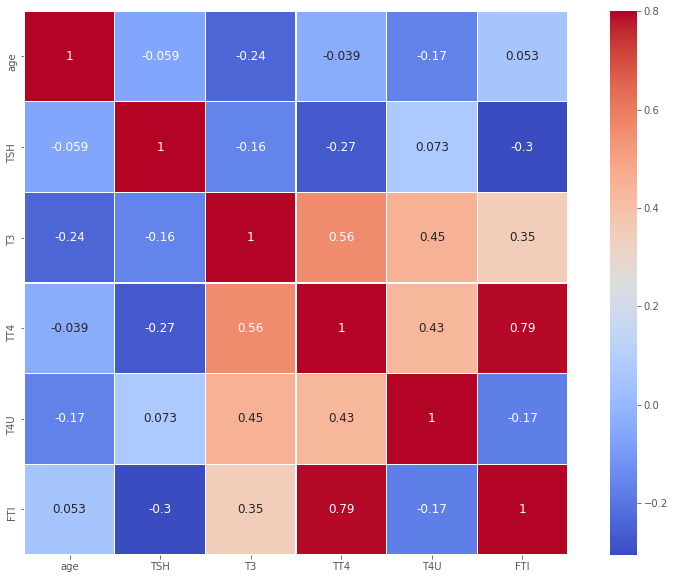

In [62]:
correlation_heatmap(data, "pearson")

we found the strong correlation between TT4 and FTI.

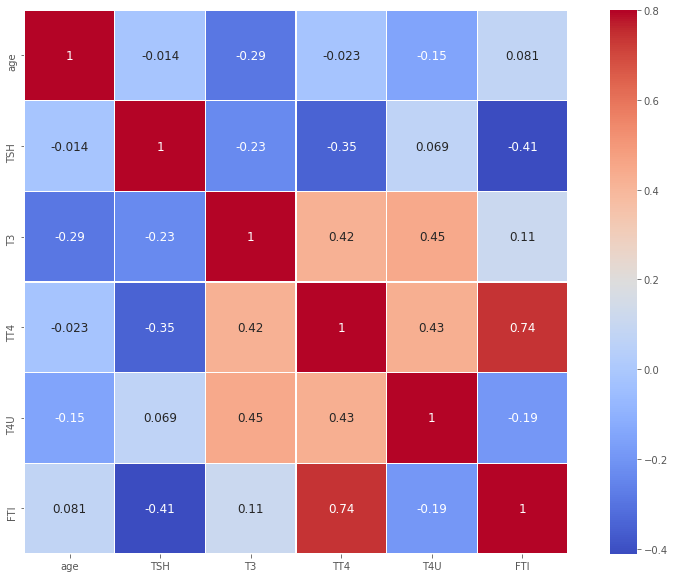

In [63]:
correlation_heatmap(data, "spearman")

strong connection remains between TT4 and FTI

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'TT4 and FTI scatter plot')

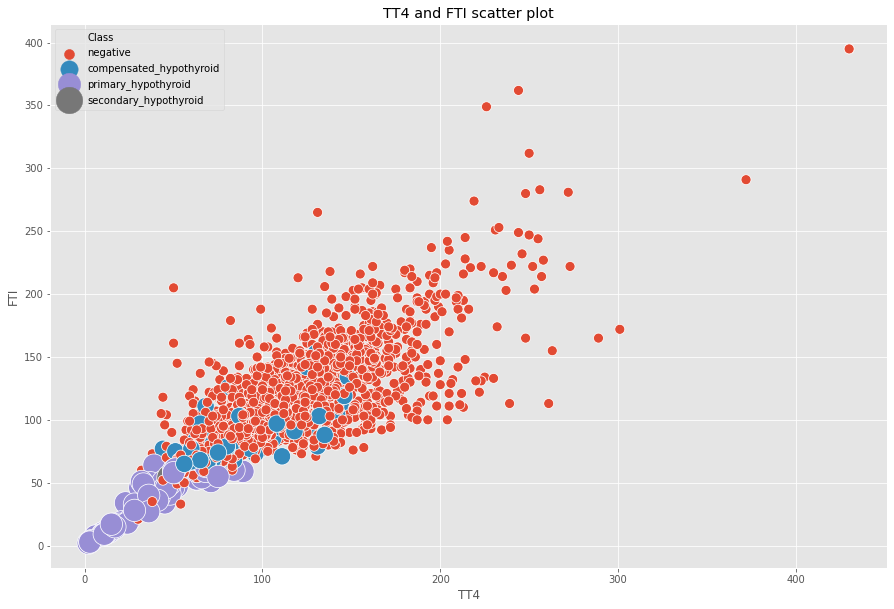

In [94]:
plt.figure(figsize=(15, 10))
plt.title("TT4 and FTI scatter plot")
# sns.scatterplot(x="TT4", y="FTI", data=data, size='Class', hue="Class", style="Class", sizes={'negative': 100, 'compensated_hypothyroid': 300, 'primary_hypothyroid': 500, 'secondary_hypothyroid': 700})
sns.scatterplot(x="TT4", y="FTI", data=data, size='Class', hue="Class", sizes={'negative': 100, 'compensated_hypothyroid': 300, 'primary_hypothyroid': 500, 'secondary_hypothyroid': 700}, hue_order=["negative", "compensated_hypothyroid", "primary_hypothyroid", "secondary_hypothyroid"])

we can assume that low levels of TT4 and FTI lead to any kind of hypothyroid. it's hard to distinct between various types of hypothyroid.

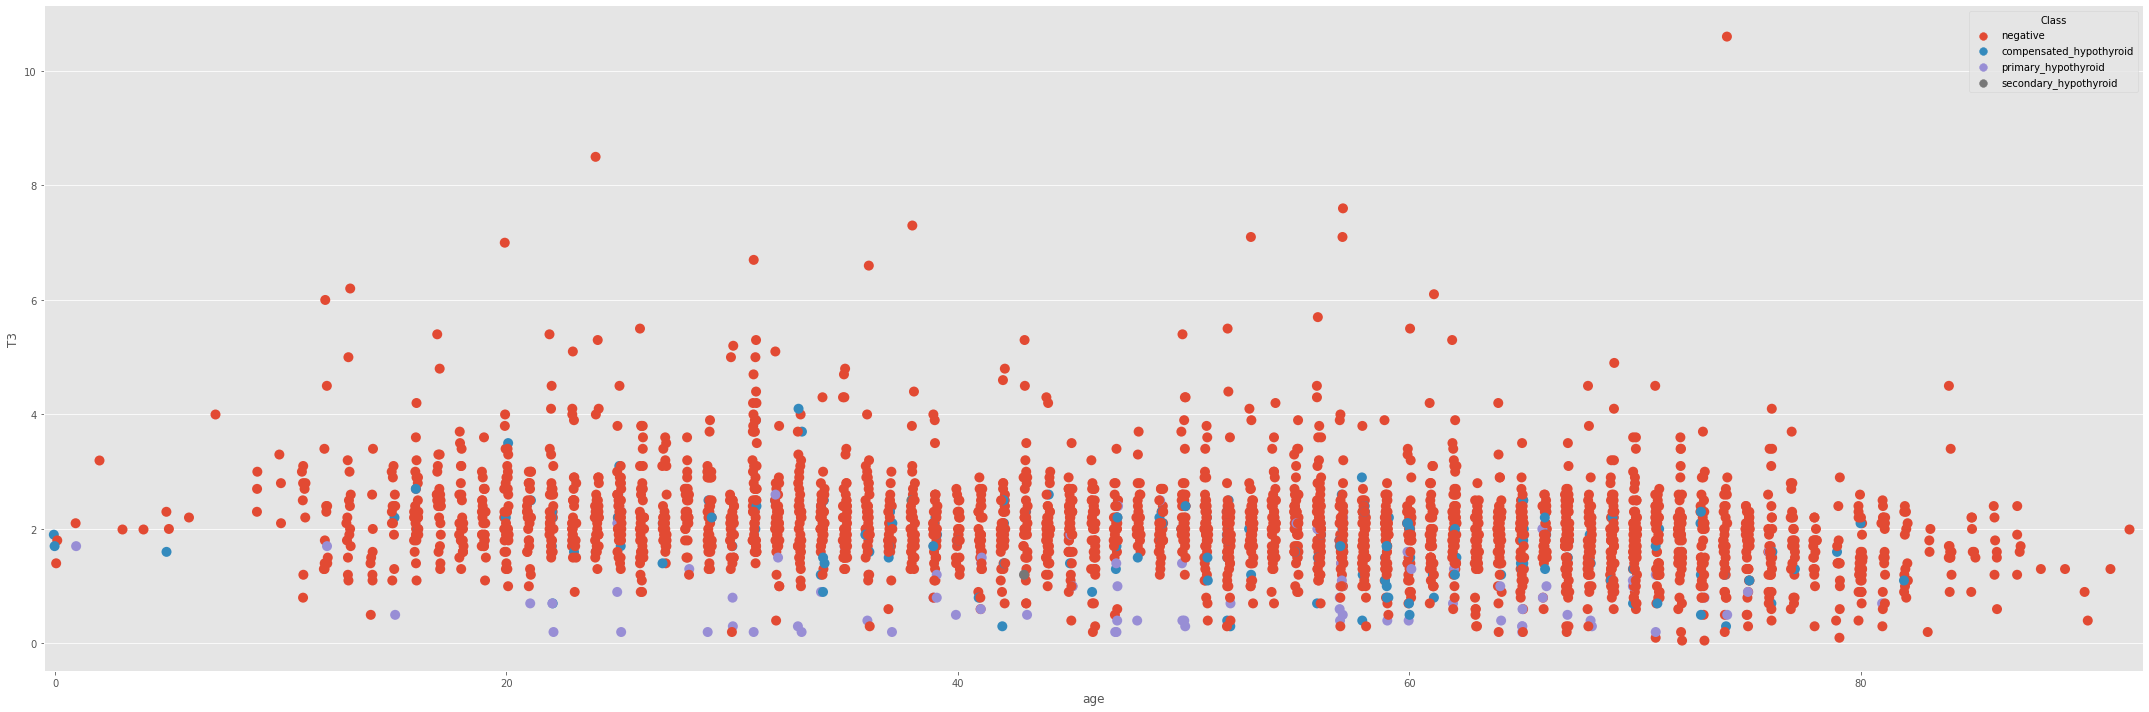

In [95]:
sns.catplot(x="age", y="T3", data=data, hue="Class", kind='strip', height=10, aspect=3, s=10, hue_order=["negative", "compensated_hypothyroid", "primary_hypothyroid", "secondary_hypothyroid"], legend_out=False)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

the plot it hard to read. we only can tell that low levels of T3 lead to primary_hypothyroid. let's convert Class variable into dummy with only 2 values = positive and negative

In [100]:
copied_df = data.copy(deep=True)
copied_df.replace(["compensated_hypothyroid", "primary_hypothyroid", "secondary_hypothyroid"], "positive", inplace=True)

<Figure size 1080x720 with 0 Axes>

Text(0.5, 1.0, 'TT4 and FTI scatter plot')

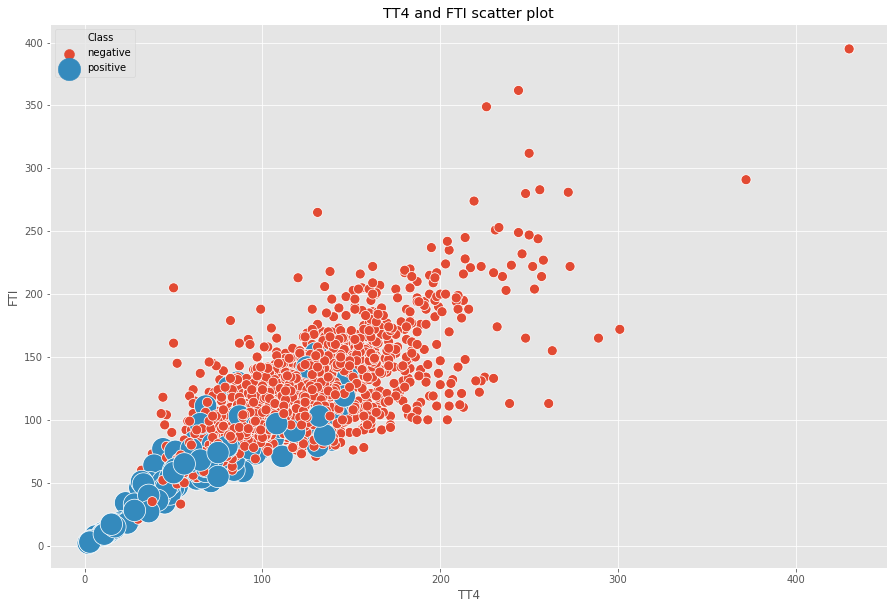

In [101]:
plt.figure(figsize=(15, 10))
plt.title("TT4 and FTI scatter plot")
# sns.scatterplot(x="TT4", y="FTI", data=data, size='Class', hue="Class", style="Class", sizes={'negative': 100, 'compensated_hypothyroid': 300, 'primary_hypothyroid': 500, 'secondary_hypothyroid': 700})
sns.scatterplot(x="TT4", y="FTI", data=copied_df, size='Class', hue="Class", sizes={'negative': 100, 'positive': 500}, hue_order=["negative","positive"])

now we can clearly see the relationship between low levels of FTI hormone and hypothyroid.

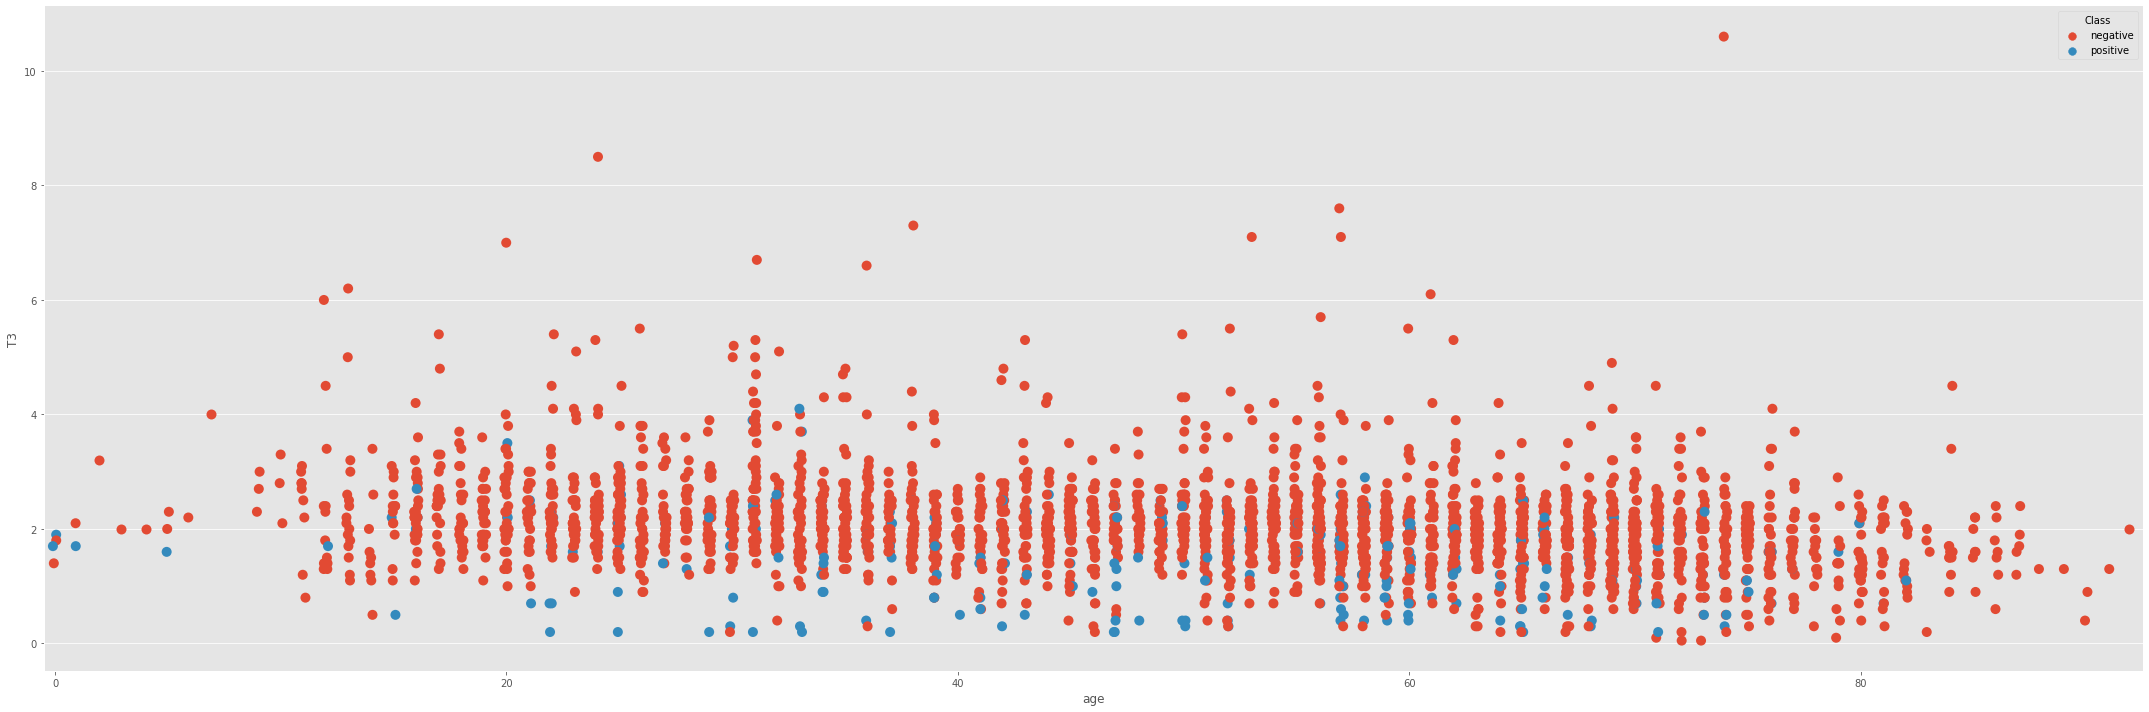

In [102]:
sns.catplot(x="age", y="T3", data=copied_df, hue="Class", kind='strip', height=10, aspect=3, s=10, hue_order=["negative", "positive"], legend_out=False)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))

now we can observe the dependency between hypothyroid and hormone levels. let's proceed to categorial features

## categorial

In [112]:
all_data = list(data)
numeric_features = ["age", "TSH", "T3", "TT4", "T4U", "FTI"]
catetogial_features = [item for item in all_data if item not in numeric_features]
print(catetogial_features)
copied_df[catetogial_features] = copied_df[catetogial_features].astype("category")
copied_df.info()

['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'referral_source', 'Class']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3771 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3771 non-null   float64 
 1   sex                        3621 non-null   category
 2   on_thyroxine               3771 non-null   category
 3   query_on_thyroxine         3771 non-null   category
 4   on_antithyroid_medication  3771 non-null   category
 5   sick                       3771 non-null   category
 6   pregnant                   3771 non-null   category
 7   thyroid_surgery      

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'sex count plot')

Text(0, 0.5, 'number of specimen')

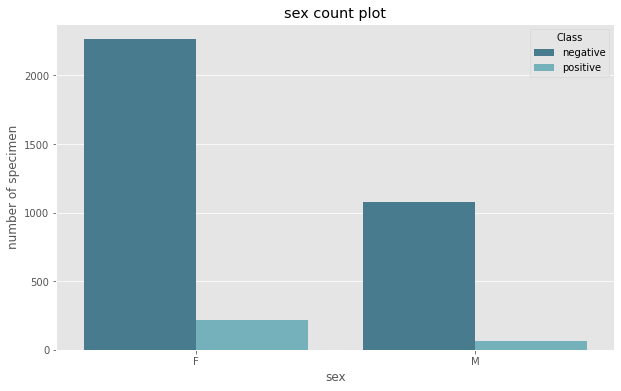

In [116]:
plt.figure(figsize=(10, 6))
plt.title("sex count plot")
sns.countplot(x='sex', data=copied_df, palette = 'GnBu_d', hue="Class")
plt.ylabel("number of specimen")